In [1]:
import polars as pl
import matplotlib.pyplot as plt

In [2]:
syukuhaku_data = pl.read_csv("data/2024延べ宿泊者.tsv", separator="\t")

syukuhaku_data.sample(5)

# 1. データの整形
# 延べ宿泊者数カンマ区切りを削除
syukuhaku_data = syukuhaku_data.with_columns(
    pl.col("観光目的宿泊者数").str.replace_all(",", "").cast(pl.Int64)
)
syukuhaku_data.sample(2)

都道府県,宿泊者数,観光目的宿泊者数
str,str,i64
"""滋賀県""","""4,770,630 """,2510110
"""山口県""","""3,633,980 """,1377080


In [3]:
# 2. データの集計
# 宿泊者の多い順に並べ替え
syukuhaku_data.sort("観光目的宿泊者数").reverse()

都道府県,宿泊者数,観光目的宿泊者数
str,str,i64
"""東京都""","""110,977,440 """,48720520
"""大阪府""","""56,455,300 """,26402310
"""京都府""","""33,168,590 """,23774520
"""北海道""","""42,017,930 """,22538200
"""沖縄県""","""31,940,360 """,20928820
…,…,…
"""埼玉県""","""5,682,350 """,1044230
"""鳥取県""","""2,937,590 """,1027490
"""岡山県""","""5,895,950 """,1001170


In [4]:
# 上位5位の総計は全体の何%か
top5 = syukuhaku_data.sort("観光目的宿泊者数").reverse().head(10).get_column("観光目的宿泊者数").sum()
top5_ken = ", ".join(syukuhaku_data.sort("観光目的宿泊者数").reverse().head(10).get_column("都道府県").to_list())
print(f"上位5位の宿泊者数: {top5} {top5_ken}")
total = syukuhaku_data.get_column("観光目的宿泊者数").sum()
print(f"全体の宿泊者数: {total}")
print(f"上位5位の宿泊者数は全体の{top5 / total * 100:.2f}%")

上位5位の宿泊者数: 202137680 東京都, 大阪府, 京都府, 北海道, 沖縄県, 千葉県, 長野県, 神奈川県, 静岡県, 兵庫県
全体の宿泊者数: 312328430
上位5位の宿泊者数は全体の64.72%


In [5]:
# 全体からの宿泊者数の割合を計算
syukuhaku_data = syukuhaku_data.with_columns(
    ((pl.col("観光目的宿泊者数") / total) * 100).alias("割合")
)
syukuhaku_data = syukuhaku_data.sort("観光目的宿泊者数").reverse()
minami_kantou = ["東京都", "神奈川県", "千葉県", "埼玉県"]
# 南関東の宿泊者数を合計
minami_kantou_sum = syukuhaku_data.filter(pl.col("都道府県").is_in(minami_kantou)).get_column("割合").sum()
print(f"南関東の宿泊者割合: {minami_kantou_sum}")
kinki = ["大阪府", "京都府", "兵庫県", "滋賀県", "奈良県", "和歌山県"]
# 近畿の宿泊者数を合計
kinki_sum = syukuhaku_data.filter(pl.col("都道府県").is_in(kinki)).get_column("割合").sum()
print(f"近畿の宿泊者割合: {kinki_sum}")
tyuubu = ["愛知県", "岐阜県", "三重県", "静岡県"]
# 中部の宿泊者数を合計
tyuubu_sum = syukuhaku_data.filter(pl.col("都道府県").is_in(tyuubu)).get_column("割合").sum()
print(f"中部の宿泊者割合: {tyuubu_sum}")
# 北海道
print(syukuhaku_data.filter(pl.col("都道府県") == "北海道").get_column("割合").sum())

南関東の宿泊者割合: 25.193102017642136
近畿の宿泊者割合: 21.09192877510382
中部の宿泊者割合: 8.640382177184446
7.216185859225176


In [6]:
tops = syukuhaku_data.sort("割合").reverse().head(10)["割合"].sum()
print(f"上位10位の宿泊者数は全体の{tops:.2f}%")
el = syukuhaku_data.sort("割合").reverse().tail(38)["割合"].mean()
print(f"その他の県の宿泊者数は平均して{el:.2f}%")

上位10位の宿泊者数は全体の64.72%
その他の県の宿泊者数は平均して0.99%


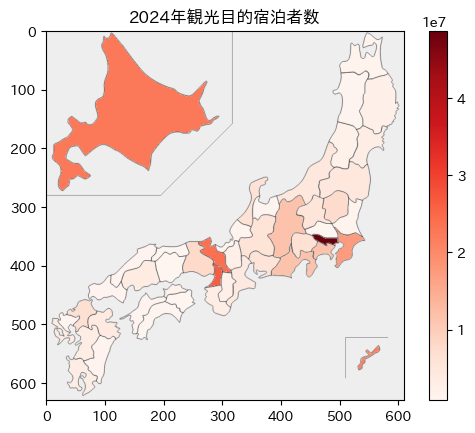

In [11]:
# 3. データの可視化 日本地図ヒートマップ
from japanmap import picture
import japanize_matplotlib
df = syukuhaku_data.to_pandas()
df = df[0:47].set_index("都道府県")
cmap = plt.get_cmap("Reds")
norm = plt.Normalize(vmin=df["観光目的宿泊者数"].min(), vmax=df["観光目的宿泊者数"].max())
plt.colorbar(plt.cm.ScalarMappable(norm, cmap), ax=plt.gca(), )
# データをSeries化する際に可視化対象のデータをカラーマップに従ってカラーコードに変換する関数を作成
def fcol(x): return '#' + bytes(cmap(norm(x), bytes=True)[:3]).hex()
plt.title("2024年観光目的宿泊者数")
plt.imshow(picture(df["観光目的宿泊者数"].apply(fcol)))

In [8]:
48 - len(minami_kantou) - len(kinki) - len(tyuubu)

34